## load libraries

In [1]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random


In [3]:
import importlib
pardir = os.path.abspath("../") 
if pardir not in sys.path:
    sys.path.append(pardir)
from utils.DLutils import *
from utils.vizutils import *
from create_toybrains import ToyBrainsData
from experiments.fit_DL_model import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


First, generate the toybrain datasets 

Refer to the notebook `toybrains/experiments/gen_lbl1cov1_configs.ipynb` for an example on how to generate the dataset.
Alternatively, if you have a config such as `configs.lbl1cov1` you can simply run,
```bash
! nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 --suffix n &> nohup1.out &
```

In [4]:
DATASETS = sorted([os.path.abspath(path) for path in glob("../dataset/toybrains_n10000_lblmidr_covsite_t*")])
print("Fitting DL model on the following toybrains datasets:")
DATASETS

Fitting DL model on the following toybrains datasets:


['/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t0',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t1',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t2',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t3',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t4']

In [5]:
# get their corresponding config files
CONFIGS = {}
for data_dir in DATASETS:
    config_file_suffix = os.path.basename(data_dir).split("_")
    config_file = glob(f"../configs/*{config_file_suffix[-2]}*/*{config_file_suffix[-1]}*.py")[0]
    CONFIGS.update({data_dir: config_file})

### Generative attr. dist.

In [6]:
# for data_dir in DATASETS:
#     data_name = data_dir.split('/')[-1]
#     df = pd.read_csv(f'{data_dir}/{data_name}.csv')
#     cov_cols = df.filter(regex='^(cov_|lbl_)').columns
#     attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
#     plot_col_dists(df, 
#                    attr_cols=attr_cols, cov_cols=cov_cols, 
#                    title=f"{data_name}: Dist. of generative data attributes vs the labels")
#     plt.show()

## Estimate ground-truth contributions
of confounding signal and the true signal

There exists a relationship, 

$ S_{total} = f(S_{conf} , S_{true}, \epsilon )$ , where $\epsilon$ is the noise added by the other image attributes.

$ S_{superset} = f(S_{conf}, S_{true})$
I need to find the function $f$ 

### (1) estimate it by fitting separate log-reg models

In [7]:
contrib_results = []
for data_dir in DATASETS:
    toy = ToyBrainsData(CONFIGS[data_dir])
    # load the already generated dataset
    toy.load_generated_dataset(data_dir)
    contrib_result = toy.fit_contrib_estimators(input_feature_sets=["attr_all", "attr_subsets", "attr_supset"],
                                                output_labels=["lbls"],
                                                CV=10)
    contrib_results.append(contrib_result)

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr_covsite_t0
 ... running a total of 40 different settings of [input] x [output] x [CV] and saving the result at /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t0


100%|██████████| 40/40 [00:14<00:00,  2.84it/s]


TOTAL RUNTIME: 0:00:15
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr_covsite_t1
 ... running a total of 40 different settings of [input] x [output] x [CV] and saving the result at /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t1


100%|██████████| 40/40 [00:02<00:00, 18.39it/s]


TOTAL RUNTIME: 0:00:03
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr_covsite_t2
 ... running a total of 40 different settings of [input] x [output] x [CV] and saving the result at /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t2


100%|██████████| 40/40 [00:02<00:00, 19.05it/s]


TOTAL RUNTIME: 0:00:03
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr_covsite_t3
 ... running a total of 40 different settings of [input] x [output] x [CV] and saving the result at /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t3


100%|██████████| 40/40 [00:02<00:00, 18.58it/s]


TOTAL RUNTIME: 0:00:03
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr_covsite_t4
 ... running a total of 40 different settings of [input] x [output] x [CV] and saving the result at /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t4


100%|██████████| 40/40 [00:02<00:00, 18.62it/s]


TOTAL RUNTIME: 0:00:03


In [8]:
show_contrib_table(contrib_results)

All results are shown in percentage (%)


### (2) estimate it using SHAP

**Derivation: SHAP to contrib score**

There is a problem with using the SHAP values directly as a proxy for grouth truth contributions of the attributes to the model prediction. We use a logistic regression model and it is NOT additive in the probability space. 

If we instead use the log-odds output of the model we see a perfect linear relationship between the models inputs and the model's outputs.

Therefore, we need to transform the SHAP values into such an additive space (lets call it `relative contrib` values) of the log-odds.

**Deriving `relative contrib` values from SHAP values:**

For a data point $X_i$, we expect the following relationship between SHAP values of different attributes for logistic regression: 

$ \text{sigmoid} ( \sum_{j}(\text{shap}(X_i, a_j)) + \text{baseshap}(X_i)) = \text{proba}(X_i) $  $\quad \quad \quad $.... ([source](https://github.com/shap/shap/issues/352#issuecomment-445925342))

$\quad \quad \quad \quad \quad \quad \quad \quad \quad$ where, $ \text{sigmoid}(x) = 1/(1+\epsilon^{-x})$


$ ( \sum_{j}(\text{shap}(X_i, a_j)) + \text{baseshap}(X_i)) = sigmoid^{-1} (proba(X_i)) $

$  \sum_{j}(\text{shap}(X_i, a_j)) = \text{logit} (proba(X_i)) - \text{baseshap}(X_i) $ $\quad \quad \quad $.... since $ sigmoid^{-1} = \text{logit}(p) = \ln \left( \frac{p}{1 - p} \right)$

For a given sample $X_i$, the right hand side of the above equation is a constant, say $C$. \
The relative contribution of each feature $a_j$ to this total $C$ is given by, 

$ \frac{\text{shap}(X_i, a_j)}{C} $  $\quad \quad \quad $....  such that,   $\sum\limits_{a_j} \frac{\text{shap}(X_i, a_j)}{C}  = 1$

Averaging this across all the dataset samples $N$, we can get the ground-truth contribution of a feature $a_j$ as a percentage, \
$ \text{contrib}(a_j) =\frac{1}{N} \times  | \sum\limits_{X_i} \frac{\text{shap}(X_i, a_j)}{C} | \times 100 $ 



### Compare SHAP with Acc
Organize the results across different datasets in a single dataframe:

Questions to address: <span style="color:green">*findings in green*</span>
1. Are the relative contributions of the confounder-driven attributes and the signal-driven attributes comparable to the model-derived estimates? <span style="color:green">Yes</span>


In [9]:
results_filtered = show_contrib_table(contrib_results,
                   avg_over_trials=False, 
                   filter_rows={"inp": ["attr_all"]},
                   filter_cols=["test_metric", "shap__brain-int_fill", "shap__shape-midr_curv", "shap__shape-midr_vol-rad"])
# results_filtered

All results are shown in percentage (%)


In [10]:
# collect the Acc scores from other input domains
results_other_acc = show_contrib_table(contrib_results,
                   avg_over_trials=False,
                   filter_cols=["test_metric"])
results_other_acc = results_other_acc.data.reset_index(level='inp')

# split the columns by the value of the input domain
df_accs = []
for inp, df_acc_i in results_other_acc.groupby('inp'):
    df_acc_i = df_acc_i.drop(columns=['inp'])
    df_acc_i = df_acc_i.rename(columns={'test_metric': inp})
    df_accs.append(df_acc_i)

results_other_acc = pd.concat(df_accs, axis=1)
# results_other_acc

All results are shown in percentage (%)


In [11]:
results_contrib = results_filtered.data.reset_index(level='inp', drop=True).drop(columns=['test_metric'])
results_contrib_all = pd.concat([results_contrib, results_other_acc], axis=1)
results_contrib_all.columns.tolist()
# results_contrib_all.style.bar(vmin=0, vmax=100)

['shap__brain-int_fill',
 'shap__shape-midr_curv',
 'shap__shape-midr_vol-rad',
 'attr_all',
 'attr_brain-int_fill',
 'attr_shape-midr_curv, shape-midr_vol-rad',
 'attr_superset']

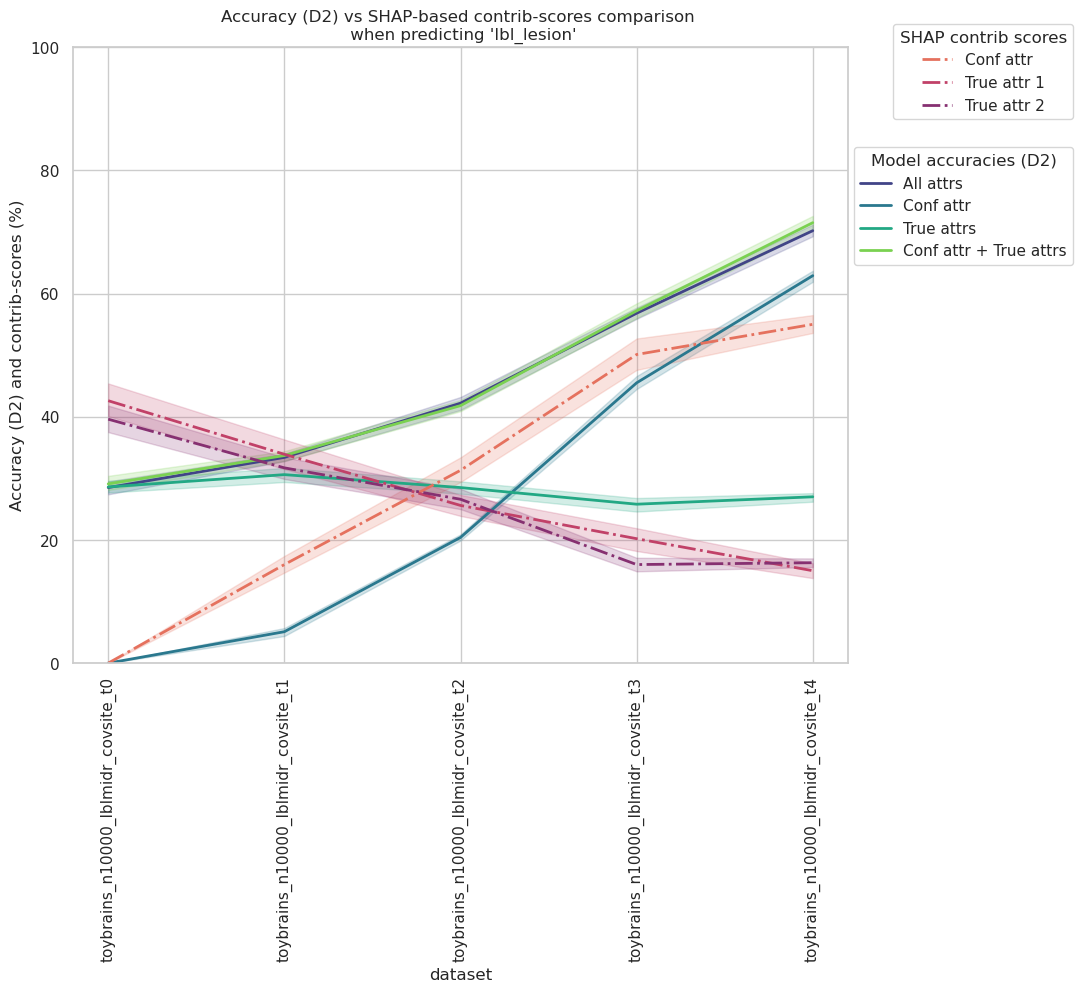

In [35]:
sns.set(rc={'figure.figsize':(10,8)}, style="whitegrid")

# map the 
# map the column names to more readable names
map_col_names = {
   "brain-int_fill" : "Conf attr"
    ,"shape-midr_curv" : "True attr 1",
    "shape-midr_vol-rad" : "True attr 2",
    'shape-midr_curv, shape-midr_vol-rad': "True attrs",
    "all": "All attrs", 
    "superset": "Conf attr + True attrs"
}

for output_label, result_dfi in results_contrib_all.reset_index().groupby('out'):
    result_dfi = result_dfi.set_index('dataset')
    # drop the trial column
    result_dfi = result_dfi.drop(columns='trial')
    # sort the column names alphabetically to improve visualization
    result_dfi = result_dfi.reindex(sorted(result_dfi.columns), axis=1)

    # plot the SHAP-contrib scores and Acc scores in two iterations with different legends
    grps = {'attr_':
            {'palette':'viridis',
             'line_style':'-',
              'legend_title':'Model accuracies (D2)'},
             'shap__':
             {'palette':'flare',
              'line_style':'-.',
             'legend_title':'SHAP contrib scores'}
            }
    legends = []
    total_lines = 0
    for i,(col_type, grp_attr) in enumerate(grps.items()):
        result_dfii = result_dfi.filter(regex=f'^{col_type}')
        new_colnames = {}
        for c in result_dfii.columns:
            new_colname = map_col_names[c.replace(col_type, '')]
            new_colnames.update({c: new_colname})
        result_dfii = result_dfii.rename(columns=new_colnames)
        # save the count of columns in the grps dict
        grps[col_type].update({'count':len(result_dfii.columns)})  
        
        ax = sns.lineplot(result_dfii, legend=(len(grps)-1),
                     palette=grp_attr["palette"]) 
        # set one line style for all lines in this group
        lines_set = 0
        for l,line in enumerate(ax.lines):
            if l>=total_lines:
                line.set_linestyle(grp_attr["line_style"])
                line.set_linewidth(2)
                lines_set += 1
        total_lines += lines_set

    # add separate legends for each group with separate titles in the end
    h,l = ax.get_legend_handles_labels()
    legends = []
    for i,(col_type, grp_attr) in enumerate(grps.items()):
        hi = h[:grp_attr["count"]] 
        li = l[:grp_attr["count"]] 
        h = h[grp_attr["count"]:]
        l = l[grp_attr["count"]:]
        legends.append(
            ax.legend(hi, li, 
                    frameon=True,
                    loc='upper right', bbox_to_anchor=(1.3, 0.85+0.2*i),
                    title=grp_attr["legend_title"]))
    # add all the legends to the figure in the end
    for leg in legends:
        if leg!=legends[-1]:
            ax.add_artist(leg)

    plt.ylim(0,100)
    plt.title(f"Accuracy (D2) vs SHAP-based contrib-scores comparison \n when predicting '{output_label}'")
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy (D2) and contrib-scores (%)")
    # plt.tight_layout()
    plt.show()
